<div align="center">
  <span style="font-size:28px;"><b>Logistic Regression for Multiclass Classification</b></span>
</div>

<div align="left">
  <span style="font-size:18px;"><b>Importing Important Libraries</b></span>
</div>

In [33]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [34]:
def extract_features_from_file(filepath, window_size=20):
    df = pd.read_csv(filepath)
    features = []

    for i in range(0, len(df), window_size):
        window = df.iloc[i:i+window_size]
        if len(window) < window_size:
            continue

        rms_ch1 = np.sqrt(np.mean(np.square(window['ch1'])))
        rms_ch2 = np.sqrt(np.mean(np.square(window['ch2'])))
        mav_ch1 = np.mean(np.abs(window['ch1']))
        mav_ch2 = np.mean(np.abs(window['ch2']))
        mse_ch1 = np.mean((window['ch1'] - window['ch1'].mean())**2)
        mse_ch2 = np.mean((window['ch2'] - window['ch2'].mean())**2)
        label = window['label'].iloc[0]

        features.append([rms_ch1, rms_ch2, mav_ch1, mav_ch2, mse_ch1, mse_ch2, label])

    return pd.DataFrame(features, columns=['rms_ch1', 'rms_ch2', 'mav_ch1', 'mav_ch2', 'mse_ch1', 'mse_ch2', 'label'])


<div align="left">
  <span style="font-size:18px;"><b>Combining All Feature Files</b></span>
</div>

In [22]:
file_names = [
    'rest_data.csv',
    'thumb_data.csv',
    'fist_data.csv',
    'okay_data.csv',
    'index_finger_data.csv',
    'peace_data.csv',
    'three_data.csv',
    'four_data.csv',
    'rock_data.csv',
    'spread_data.csv',
    'clenched_data.csv',
    'up_data.csv'
]


all_data = []

for file in file_names:
    df_features = extract_features_from_file(file)
    all_data.append(df_features)

full_dataset = pd.concat(all_data, ignore_index=True)
print("Combined dataset shape:", full_dataset.shape)
full_dataset.head()

Combined dataset shape: (3600, 7)


,rms_ch1,rms_ch2,mav_ch1,mav_ch2,mse_ch1,mse_ch2,label
0,521.123162,502.872151,520.85,502.7,284.6275,173.11,rest
1,529.038893,505.995553,528.85,505.8,199.8275,197.86,rest
2,524.686716,504.043847,524.55,503.8,143.4475,245.76,rest
3,526.525973,510.078033,526.30,509.9,237.9100,181.59,rest
4,519.968364,503.218144,519.80,503.0,175.0600,219.50,rest


<div align="left">
  <span style="font-size:18px;"><b>Encoding the Labels</b></span>
</div>

In [23]:
le = LabelEncoder()
full_dataset['label_encoded'] = le.fit_transform(full_dataset['label'])

label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print("Label mapping:")
print(label_mapping)

Label mapping:
{0: 'clenched', 1: 'fist', 2: 'four', 3: 'index_finger', 4: 'okay', 5: 'peace', 6: 'rest', 7: 'rock', 8: 'spread', 9: 'three', 10: 'thumb', 11: 'up'}


<div align="left">
  <span style="font-size:18px;"><b>Splitting the Dataset</b></span>
</div>

In [24]:
X = full_dataset.drop(['label', 'label_encoded'], axis=1)
y = full_dataset['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (2880, 6)
Test shape: (720, 6)


<div align="left">
  <span style="font-size:18px;"><b>Training a Logistic Regression Model</b></span>
</div>

In [25]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

<div align="left">
  <span style="font-size:18px;"><b>Evaluating the Model</b></span>
</div>

In [30]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

cm = confusion_matrix(y_test, y_pred)

Classification Report:

              precision    recall  f1-score   support

    clenched       0.06      0.02      0.03        60
        fist       0.09      0.32      0.14        60
        four       0.09      0.17      0.12        60
index_finger       0.00      0.00      0.00        60
        okay       0.00      0.00      0.00        60
       peace       0.11      0.17      0.13        60
        rest       0.00      0.00      0.00        60
        rock       0.04      0.02      0.02        60
      spread       0.08      0.20      0.11        60
       three       0.07      0.10      0.08        60
       thumb       0.00      0.00      0.00        60
          up       0.00      0.00      0.00        60

    accuracy                           0.08       720
   macro avg       0.04      0.08      0.05       720
weighted avg       0.04      0.08      0.05       720



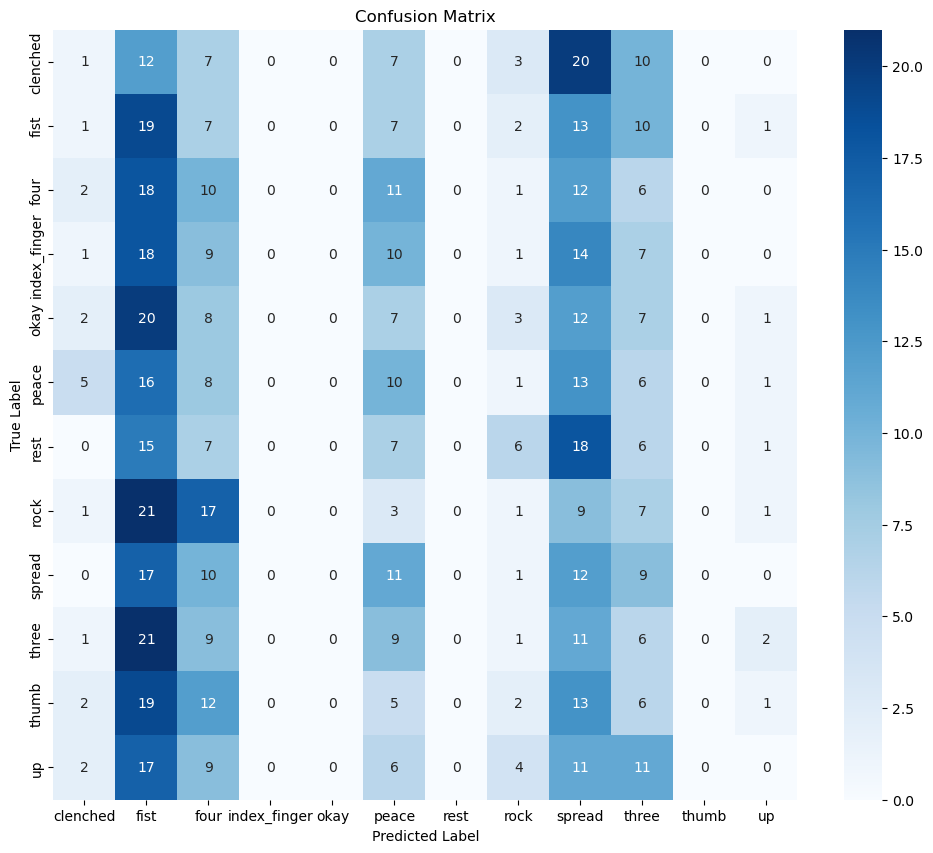

In [28]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

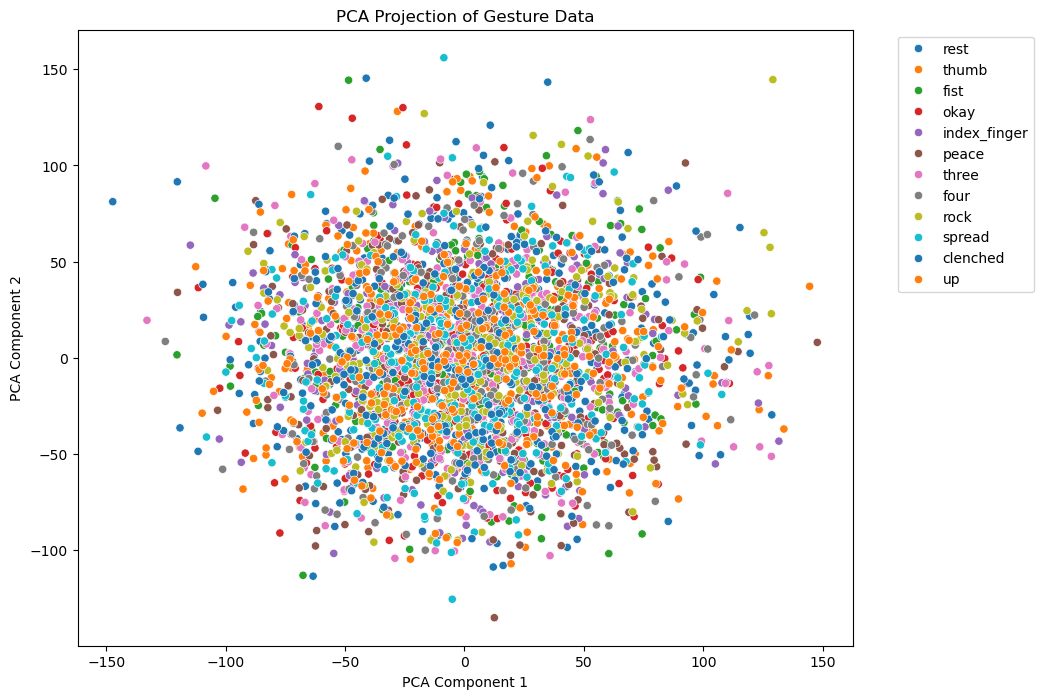

In [29]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=le.inverse_transform(y), palette='tab10')
plt.title("PCA Projection of Gesture Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<div align="center">
  <span style="font-size:22px;"><b>That's it for Multiclass Classification using Logistic Regression!</b></span>
</div>